In [113]:
#!pip install --user pyarrow
#!pip install --user -U pandas

In [1]:
import bioframe as bf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from scipy.stats import spearmanr, mannwhitneyu, fisher_exact
from scipy.special import expit as sigmoid
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc

In [2]:
conservation = pd.read_csv("../data/vep/conservation/Chr5.tsv.gz", sep="\t")
conservation

,pos,PhastCons,PhyloP
0,73,0.137841,0.486723
1,74,0.120058,0.630370
2,75,0.082986,-0.672660
3,76,0.083501,0.630370
4,77,0.070315,0.410230
...,...,...,...
24279498,26975493,0.149043,0.383414
24279499,26975494,0.139126,0.383414
24279500,26975495,0.121064,-0.819180
24279501,26975496,0.144156,0.383414


In [10]:
repeats = pd.read_csv("../data/mlm/repeats.bed.gz", sep="\t").rename(columns=dict(genoName="chrom", genoStart="start", genoEnd="end"))
repeats = repeats.query('chrom == "Chr5"')
repeats

,#bin,swScore,milliDiv,milliDel,milliIns,chrom,start,end,genoLeft,strand,repName,repClass,repFamily,repStart,repEnd,repLeft,id
54049,10,5820,34,4,1,Chr5,12582862,12583548,-14391954,+,ATCopia28_I-int,LTR,Copia,4019,4706,0,5
54050,10,636,309,61,82,Chr5,14679692,14680605,-12294897,-,ATMU1,DNA,MULE-MuDR,-2610,2319,902,5
54051,77,16502,18,0,1,Chr5,5111367,5113250,-21862252,+,ATMU12,DNA,MULE-MuDR,1,1882,-2465,5
54052,78,16,132,0,0,Chr5,6160375,6160400,-20815102,+,(T)n,Simple_repeat,Simple_repeat,1,25,0,5
54053,81,19,219,24,74,Chr5,9043941,9044026,-17931476,+,GA-rich,Low_complexity,Low_complexity,1,81,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69150,790,18,171,42,20,Chr5,26965927,26965975,-9527,+,GA-rich,Low_complexity,Low_complexity,1,49,0,6
69151,790,22,0,0,0,Chr5,26966363,26966387,-9115,+,(T)n,Simple_repeat,Simple_repeat,1,24,0,6
69152,790,15,55,0,0,Chr5,26970597,26970616,-4886,+,(T)n,Simple_repeat,Simple_repeat,1,19,0,6
69153,790,12,218,27,0,Chr5,26971035,26971072,-4430,+,A-rich,Low_complexity,Low_complexity,1,38,0,6


In [20]:
def compute_odds_ratio(df, threshold_quantile, print_table=False, bootstrap_seed=None):
    df = df.copy()
    if bootstrap_seed is not None:
        df = df.sample(frac=1.0, replace=True, random_state=bootstrap_seed)
    threshold = df.model_score.quantile(threshold_quantile)
    df.loc[df.model_score <= threshold, "ModelScoreTier"] = "Low"
    df.loc[df.model_score > threshold, "ModelScoreTier"] = "High"
    df.ModelScoreTier = df.ModelScoreTier.astype('category')
    group_counts = df.groupby(["Status", "ModelScoreTier"]).size()
    
    #print("Adding 1 pseudocount")
    #group_counts += 1
    if print_table:
        print(group_counts)
    
    group_counts2 = group_counts.copy()
    #print(threshold_quantile, threshold, group_counts["Rare", "Low"]+group_counts["Common", "Low"], df.model_score.min())
    group_counts = group_counts.values.reshape((2, 2))
    min_counts = group_counts.min()
    odds_ratio, p_value = fisher_exact(group_counts, alternative='greater')
    if np.isinf(odds_ratio):
        print(odds_ratio, p_value, group_counts2)
    return odds_ratio, p_value, min_counts


def compute_vep_scores(model_name):
    print(model_name)
    if model_name in ["PhastCons", "PhyloP", "PhyloP_ReLU", "PhyloP_abs"]:
        df = pd.read_parquet("../data/vep/variants/filt.parquet")
    else:
        #vep_mode, model_name2 = model_name.split("/")
        #df = pd.read_parquet(f"../plantbert/{vep_mode}/vep_full_{model_name2}.parquet")
        df = pd.read_parquet(model_name)
        if "mlm" in model_name:
            vep_mode = "mlm"
        elif "chromatin" in model_name:
            vep_mode = "chromatin"
    df = df[df.AN >= 2000]
    df = df[(df.AC != 0) & (df.AC != df.AN)]
    df["AF"] = df.AC / df.AN
    df = df[df.AF < 0.5]
    df = df.merge(conservation, how="inner", on="pos")
    df.consequence = df.consequence.apply(lambda x: ','.join(sorted(list(set(x.split(","))))))
    
    df["chrom"] = df.chromosome
    df["start"] = df.pos
    df["end"] = df.start + 1
    df = bf.coverage(df, repeats)
    
    df.loc[df.coverage==1, "consequence"] = "repeat"
    #print(df.consequence.value_counts().head(20))
    #raise Exception("debug")
    #print(df.shape)
    #df = df.query('coverage == 0')
    #print(df.shape)
    
    # TODO: figure this out
    #df.loc[(df.dist_to_TSS >= -1000) & (df.dist_to_TSS <= 0) & (df.consequence=="upstream_gene_variant"), "consequence"] = "upstream_1kb"
    
    # TODO: for loop
    #rare_thresholds = np.arange(2, 12, 2)
    #common_thresholds = np.arange(10, 110, 10)
    
    df["Status"] = "Neither"
    df.loc[df.AC <= 2, "Status"] = "Rare"
    df.loc[df.AC >= 20, "Status"] = "Common"
    df = df[df.Status!="Neither"]
    df.Status = df.Status.astype('category')
    #raise Exception("debug")
    
    if model_name == "PhastCons":
        df["model_score"] = -df.PhastCons
    elif model_name == "PhyloP":
        df["model_score"] = -(df.PhyloP)
    elif vep_mode == "chromatin":
        pred_ref_cols = df.columns[df.columns.str.startswith("model_pred_ref_")]
        pred_alt_cols = df.columns[df.columns.str.startswith("model_pred_alt_")]
        pred_cols = np.concatenate([pred_ref_cols, pred_alt_cols])
        df[pred_cols] = sigmoid(df[pred_cols])
        feature_names = ["_".join(col.split("_")[3:]) for col in pred_ref_cols]
        delta_pred_cols = [f"delta_pred_{f}" for f in feature_names]
        df.loc[:, delta_pred_cols] = df[pred_alt_cols].values - df[pred_ref_cols].values
        df.loc[:, "model_score"] = -np.linalg.norm(df[delta_pred_cols].abs().values, ord=2, axis=1)
        df.drop(columns=np.concatenate([pred_cols, delta_pred_cols]), inplace=True)
    elif vep_mode == "mlm":
        df["model_score"] = df.model_llr
        
    threshold_quantiles = np.logspace(-3, -1, 10)
    bootstrap_seeds = np.arange(30)
    
    categories = ["all"] + df.consequence.value_counts()[:9].index.values.tolist()
    
    all_results = []
    for category in categories:
        #print(category)
        df_category = df if category == "all" else df[df.consequence==category]
        
        odds_ratios, p_values, min_counts = zip(*[compute_odds_ratio(df_category, threshold_quantile) for threshold_quantile in threshold_quantiles])
        results = pd.DataFrame(dict(threshold_quantile=threshold_quantiles, odds_ratio=odds_ratios, p_value=p_values, min_count=min_counts))
        results["Test"] = "Odds-ratio"
        
        
        for bootstrap_seed in bootstrap_seeds:
            odds_ratios = [compute_odds_ratio(df_category, threshold_quantile, bootstrap_seed=bootstrap_seed)[0] for threshold_quantile in threshold_quantiles]
            #print(odds_ratios)
            #raise Exception("debug")
            results = pd.concat([
                results,
                pd.DataFrame({
                    "Test": ["Odds-ratio-bootstrap"] * len(threshold_quantiles),
                    "threshold_quantile": threshold_quantiles,
                    "bootstrap_seed": [bootstrap_seed] * len(threshold_quantiles),
                    "odds_ratio": odds_ratios,
                    "p_value": p_values, "min_count": min_counts,  # from the non-bootstrapped test
                })],
                ignore_index=True
            )
            #print(results)
            #raise Exception("debug")
        
        results = results.append({
            "Test": "Mann-Whitney",
            "p_value": mannwhitneyu(df_category.loc[df.Status=="Rare", "model_score"], df_category.loc[df.Status=="Common", "model_score"], alternative="less").pvalue
        }, ignore_index=True)
        
        results = results.append({
            "Test": "AUROC",
            "AUROC": roc_auc_score((df_category.Status=="Rare").values, -df_category.model_score.values)
        }, ignore_index=True)
        
        precision, recall, thresholds = precision_recall_curve((df_category.Status=="Rare").values, -df_category.model_score.values)
        results = results.append({
            "Test": "AUPRC",
            "AUPRC": auc(recall, precision),
        }, ignore_index=True)
        
        results["Category"] = category
        all_results.append(results)
    all_results = pd.concat(all_results, ignore_index=True)
    all_results["Model"] = model_name
    all_results["Significant"] = all_results.p_value < 0.05
    
    return all_results, df

In [21]:
model_names = [
    #"../plantbert/mlm/results/vep/.._.._data_vep_variants_filt.Chr5.parquet/results_512_convnet_only_athaliana_checkpoint-1000000/results.parquet",
    #"../plantbert/mlm/vep_full_results_512_convnet_checkpoint-1000000.parquet",
    "../plantbert/mlm/results/vep/.._.._data_vep_variants_filt.Chr5.parquet/results_512_convnet_ftAth_alone_checkpoint-1000000/results.parquet",
    "../plantbert/mlm/results/vep/.._.._data_vep_variants_filt.Chr5.parquet/results_checkpoints_512_no_repeats_convnet_pretrained_v2_checkpoint-200000/results.parquet",
    #"mlm/ensemble_3.avg",
    #"mlm/ensemble_3.min",
    #"mlm/results_512_convnet_checkpoint-1000000",
    #"mlm/results_512_convnet_ftAth_alone_checkpoint-100000",
    #"mlm/results_512_convnet_ftAth_alone_checkpoint-800000",
    #"mlm/window-512_tokenization-no_model-convnet200k",
    #"mlm/window-512_tokenization-no_model-convnet",
    #"mlm/window-512_tokenization-no_model-convnet800k",
    #"mlm/window-512_tokenization-no_model-convnet800kfinetune150k",
    #"mlm/window-512_tokenization-no_model-convnet800kfinetune200k",
    #"mlm/window-512_tokenization-no_model-convnet_only_athaliana",
    #"mlm/window-512_tokenization-no_model-convnet_ftAth_alone",
    #"mlm/window-512_tokenization-no_model-convnet_ftAth_alone",
    #"mlm/window-512_tokenization-no_model-convnet_ftAth",
    #"mlm/DNABERT",
    #"chromatin/ConvNet",
    #"chromatin/DNABERT",
    #"chromatin/DeepSEA",
    #"PhastCons",
    #"PhyloP",
]

results = pd.concat(
    [compute_vep_scores(model_name)[0] for model_name in model_names],
    ignore_index=True
)

../plantbert/mlm/results/vep/.._.._data_vep_variants_filt.Chr5.parquet/results_512_convnet_ftAth_alone_checkpoint-1000000/results.parquet
../plantbert/mlm/results/vep/.._.._data_vep_variants_filt.Chr5.parquet/results_checkpoints_512_no_repeats_convnet_pretrained_v2_checkpoint-200000/results.parquet


In [41]:
#results.to_csv(f"foo.tsv.gz", sep="\t", index=False)
#results = pd.read_csv("foo.tsv.gz", sep="\t")

In [7]:
results

,threshold_quantile,odds_ratio,p_value,min_count,Test,bootstrap_seed,AUROC,AUPRC,Category,Model,Significant
0,0.001000,2.711441,1.347394e-41,201.0,Odds-ratio,NaN,NaN,NaN,all,../plantbert/mlm/results/vep/.._.._data_vep_va...,True
1,0.001668,2.481251,2.841916e-58,359.0,Odds-ratio,NaN,NaN,NaN,all,../plantbert/mlm/results/vep/.._.._data_vep_va...,True
2,0.002783,2.240122,5.624091e-78,647.0,Odds-ratio,NaN,NaN,NaN,all,../plantbert/mlm/results/vep/.._.._data_vep_va...,True
3,0.004642,2.010871,1.446990e-99,1169.0,Odds-ratio,NaN,NaN,NaN,all,../plantbert/mlm/results/vep/.._.._data_vep_va...,True
4,0.007743,1.839152,4.719558e-128,2080.0,Odds-ratio,NaN,NaN,NaN,all,../plantbert/mlm/results/vep/.._.._data_vep_va...,True
...,...,...,...,...,...,...,...,...,...,...,...
5629,0.059948,1.428953,8.882236e-11,665.0,Odds-ratio-bootstrap,29.0,NaN,NaN,downstream_gene_variant,../plantbert/mlm/results/vep/.._.._data_vep_va...,True
5630,0.100000,1.293083,8.406479e-12,1153.0,Odds-ratio-bootstrap,29.0,NaN,NaN,downstream_gene_variant,../plantbert/mlm/results/vep/.._.._data_vep_va...,True
5631,NaN,NaN,1.182047e-16,NaN,Mann-Whitney,NaN,NaN,NaN,downstream_gene_variant,../plantbert/mlm/results/vep/.._.._data_vep_va...,True
5632,NaN,NaN,NaN,NaN,AUROC,NaN,0.527226,NaN,downstream_gene_variant,../plantbert/mlm/results/vep/.._.._data_vep_va...,False


In [55]:
#results.Model.replace({"mlm/window-512_tokenization-no_model-convnet200k": "mlm/ConvNet-200k"}, inplace=True)
#results.Model.replace({"mlm/window-512_tokenization-no_model-convnet": "mlm/ConvNet-400k"}, inplace=True)
#results.Model.replace({"mlm/window-512_tokenization-no_model-convnet800k": "mlm/ConvNet-800k"}, inplace=True)
#results.Model.replace({"mlm/window-512_tokenization-no_model-convnet800k": "mlm/ConvNet"}, inplace=True)
#results.Model.replace({"mlm/window-512_tokenization-no_model-convnet800kfinetune150k": "mlm/ConvNet-finetune-athaliana"}, inplace=True)
results.Model.replace({"mlm/window-512_tokenization-no_model-convnet800kfinetune200k": "mlm/ConvNet"}, inplace=True)
#results.Model.replace({"mlm/window-512_tokenization-no_model-convnet800kfinetune200k": "ConvNet (800k 20 species + 200k only Arabidopsis)"}, inplace=True)
#results.Model.replace({"mlm/window-512_tokenization-no_model-convnet_only_athaliana": "ConvNet (500k only Arabidopsis)"}, inplace=True)

In [8]:
# deal with infinite odds ratio
results.odds_ratio.max()

inf

In [24]:
#results.odds_ratio.replace({np.inf: 20.0}, inplace=True)

In [25]:
#results.odds_ratio.max()

4.047146289496351

In [72]:
#results = results[~(results.Model.isin(["PhyloP_abs", "PhyloP_ReLU"]))]

In [73]:
#results = results[results.Model.str.contains("mlm/ConvNet")]

In [6]:
#results = results[~results.Model.str.contains("00k")]

In [4]:
df = compute_vep_scores("mlm/window-512_tokenization-no_model-convnet800kfinetune200k")[1]

mlm/window-512_tokenization-no_model-convnet800kfinetune200k
Rare      512513
Common    394733
Name: Status, dtype: int64


In [8]:
consequence_value_counts = df.consequence.value_counts()

In [9]:
def get_category_n(category):
    if category == "all": return len(df)
    return consequence_value_counts[category]

In [27]:
results["category_n"] = results.Category + " (n=" + results.Category.apply(get_category_n).astype(str) + ")"
results.category_n

0                         all (n=907246)
1                         all (n=907246)
2                         all (n=907246)
3                         all (n=907246)
4                         all (n=907246)
                     ...                
346    downstream_gene_variant (n=30852)
347    downstream_gene_variant (n=30852)
348    downstream_gene_variant (n=30852)
349    downstream_gene_variant (n=30852)
350    downstream_gene_variant (n=30852)
Name: category_n, Length: 351, dtype: object

In [37]:
results

,threshold_quantile,odds_ratio,p_value,min_count,Test,bootstrap_seed,AUROC,AUPRC,Category,Model,Significant
0,0.001000,2.499754,3.484416e-36,214.0,Odds-ratio,NaN,NaN,NaN,all,mlm/window-512_tokenization-no_model-convnet80...,True
1,0.001668,2.393001,2.129182e-54,369.0,Odds-ratio,NaN,NaN,NaN,all,mlm/window-512_tokenization-no_model-convnet80...,True
2,0.002783,2.306881,5.628154e-83,633.0,Odds-ratio,NaN,NaN,NaN,all,mlm/window-512_tokenization-no_model-convnet80...,True
3,0.004642,2.167365,2.113629e-119,1107.0,Odds-ratio,NaN,NaN,NaN,all,mlm/window-512_tokenization-no_model-convnet80...,True
4,0.007743,2.017399,1.189218e-165,1948.0,Odds-ratio,NaN,NaN,NaN,all,mlm/window-512_tokenization-no_model-convnet80...,True
...,...,...,...,...,...,...,...,...,...,...,...
769,0.059948,1.192584,NaN,NaN,Odds-ratio-bootstrap,2.0,NaN,NaN,downstream_gene_variant,PhyloP,False
770,0.100000,1.169115,NaN,NaN,Odds-ratio-bootstrap,2.0,NaN,NaN,downstream_gene_variant,PhyloP,False
771,NaN,NaN,1.744197e-26,NaN,Mann-Whitney,NaN,NaN,NaN,downstream_gene_variant,PhyloP,True
772,NaN,NaN,NaN,NaN,AUROC,NaN,0.535136,NaN,downstream_gene_variant,PhyloP,False


In [22]:
results.Model.replace({"mlm/results_512_convnet_checkpoint-1000000": "1M(all)"}, inplace=True)
results.Model.replace({"mlm/results_512_convnet_ftAth_alone_checkpoint-100000": "1M(all)->100K(arabidopsis)"}, inplace=True)
results.Model.replace({"mlm/results_512_convnet_ftAth_alone_checkpoint-800000": "1M(all)->800K(arabidopsis)"}, inplace=True)

In [22]:
results.Model.replace({"../plantbert/mlm/results/vep/.._.._data_vep_variants_filt.Chr5.parquet/results_512_convnet_ftAth_alone_checkpoint-1000000/results.parquet": "Base model"}, inplace=True)
results.Model.replace({"../plantbert/mlm/results/vep/.._.._data_vep_variants_filt.Chr5.parquet/results_checkpoints_512_no_repeats_convnet_pretrained_v2_checkpoint-200000/results.parquet": "Base model -> pretrain w/o loss on repeats"}, inplace=True)

In [56]:
results.Model.replace({
    "../plantbert/mlm/results/vep/.._.._data_vep_variants_filt.Chr5.parquet/results_512_convnet_only_athaliana_checkpoint-1000000/results.parquet": "1M(Ath)",
    "../plantbert/mlm/vep_full_results_512_convnet_checkpoint-1000000.parquet": "1M(All)",
    "../plantbert/mlm/results/vep/.._.._data_vep_variants_filt.Chr5.parquet/results_512_convnet_ftAth_alone_checkpoint-1000000/results.parquet": "1M(All)->1M(Ath)"
    },
    inplace=True,
)

In [23]:
results.Model.value_counts()

Base model                                    3130
Base model -> pretrain w/o loss on repeats    3130
Name: Model, dtype: int64

In [44]:
results.sort_values("Model", kind="stable", inplace=True)

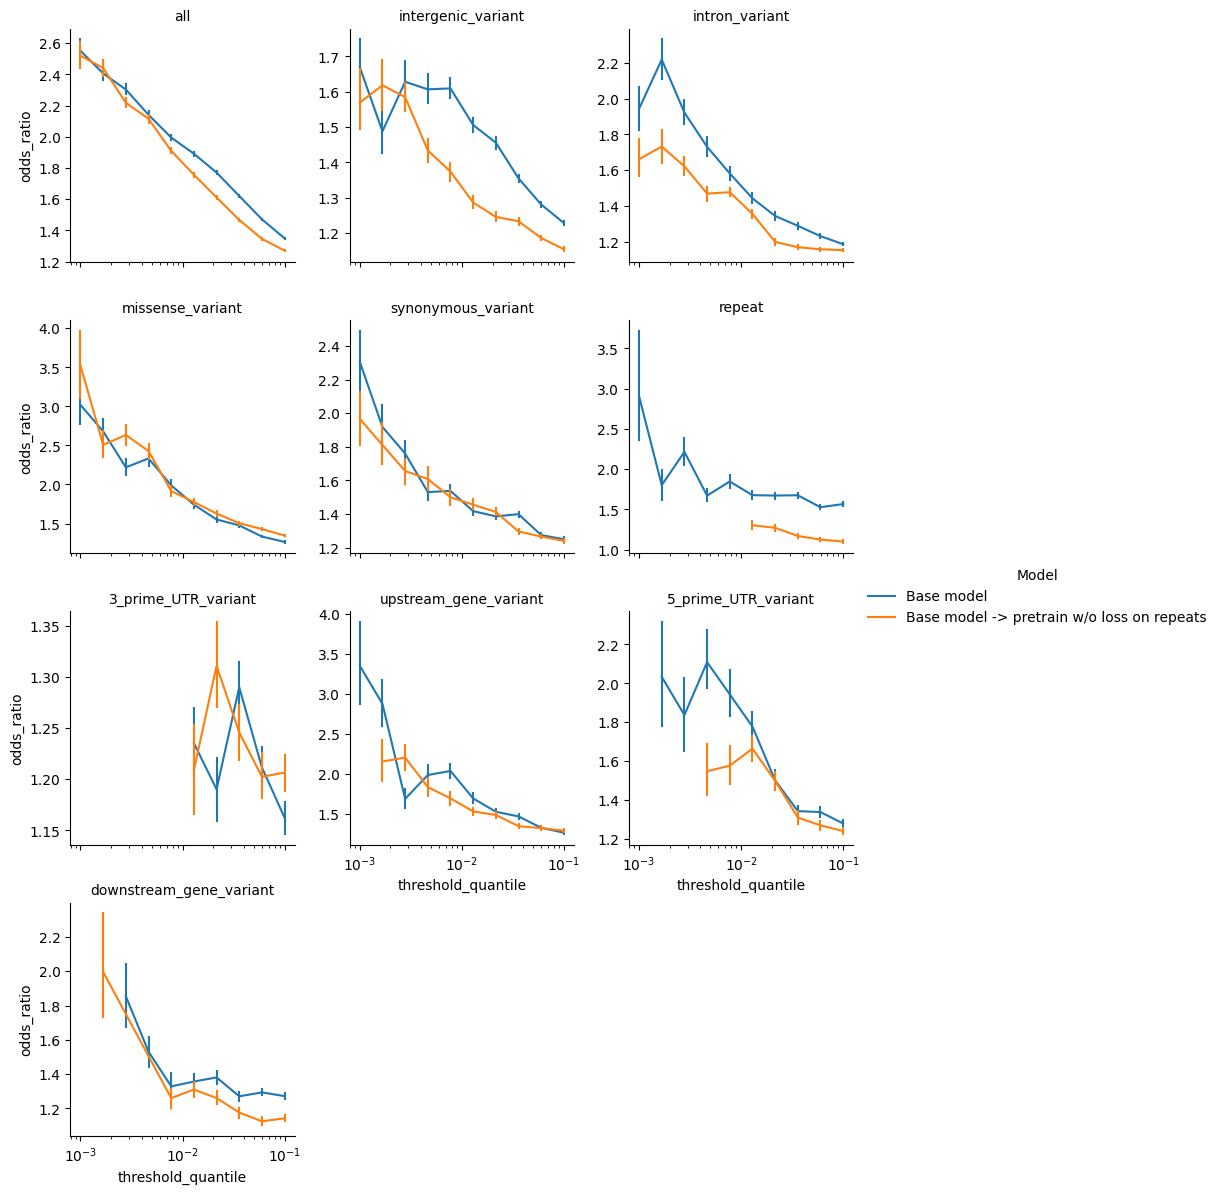

In [24]:
g = sns.relplot(
    #data=results[(results.Test=="Odds-ratio")&(results.min_count >= 5)],
    data=results[(results.Test=="Odds-ratio-bootstrap") & (results.Significant)],
    x="threshold_quantile",
    y="odds_ratio",
    hue="Model",
    #style="Significant",
    style_order=[True, False],
    #col="category_n",
    col="Category",
    height=3,
    #aspect=.7,
    kind="line",
    markers=True,
    col_wrap=3,
    facet_kws={'sharey': False, 'sharex': True},
    err_style="bars",
    #err_style=None,
)
g.set_titles(col_template="{col_name}", row_template="{row_name}")
g.set(xscale='log');
#plt.savefig("odds_ratios.svg", bbox_inches='tight')
#plt.savefig("odds_ratios_3.pdf", bbox_inches='tight')

In [10]:
results_mw = results[results.Test=="Mann-Whitney"]
results_mw

,threshold_quantile,odds_ratio,p_value,min_count,Test,bootstrap_seed,AUROC,AUPRC,Category,Model,Significant
310,NaN,NaN,0.000000e+00,NaN,Mann-Whitney,NaN,NaN,NaN,all,../plantbert/mlm/results/vep/.._.._data_vep_va...,True
623,NaN,NaN,1.387913e-96,NaN,Mann-Whitney,NaN,NaN,NaN,intergenic_variant,../plantbert/mlm/results/vep/.._.._data_vep_va...,True
936,NaN,NaN,2.213030e-36,NaN,Mann-Whitney,NaN,NaN,NaN,intron_variant,../plantbert/mlm/results/vep/.._.._data_vep_va...,True
1249,NaN,NaN,2.675576e-98,NaN,Mann-Whitney,NaN,NaN,NaN,missense_variant,../plantbert/mlm/results/vep/.._.._data_vep_va...,True
1562,NaN,NaN,2.197776e-74,NaN,Mann-Whitney,NaN,NaN,NaN,synonymous_variant,../plantbert/mlm/results/vep/.._.._data_vep_va...,True
1875,NaN,NaN,2.427227e-15,NaN,Mann-Whitney,NaN,NaN,NaN,3_prime_UTR_variant,../plantbert/mlm/results/vep/.._.._data_vep_va...,True
2188,NaN,NaN,2.115005e-22,NaN,Mann-Whitney,NaN,NaN,NaN,upstream_gene_variant,../plantbert/mlm/results/vep/.._.._data_vep_va...,True
2501,NaN,NaN,1.309248e-27,NaN,Mann-Whitney,NaN,NaN,NaN,5_prime_UTR_variant,../plantbert/mlm/results/vep/.._.._data_vep_va...,True
2814,NaN,NaN,2.611153e-10,NaN,Mann-Whitney,NaN,NaN,NaN,downstream_gene_variant,../plantbert/mlm/results/vep/.._.._data_vep_va...,True
3127,NaN,NaN,0.000000e+00,NaN,Mann-Whitney,NaN,NaN,NaN,all,../plantbert/mlm/results/vep/.._.._data_vep_va...,True


In [11]:
results_mw["-log10_pvalue"] = results_mw.p_value.apply(lambda p_value: 300 if p_value==0.0 else -np.log10(p_value))

/global/software/sl-7.x86_64/modules/langs/python/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Text(0.5, 0, 'Mann-Whitney -log10_pvalue')

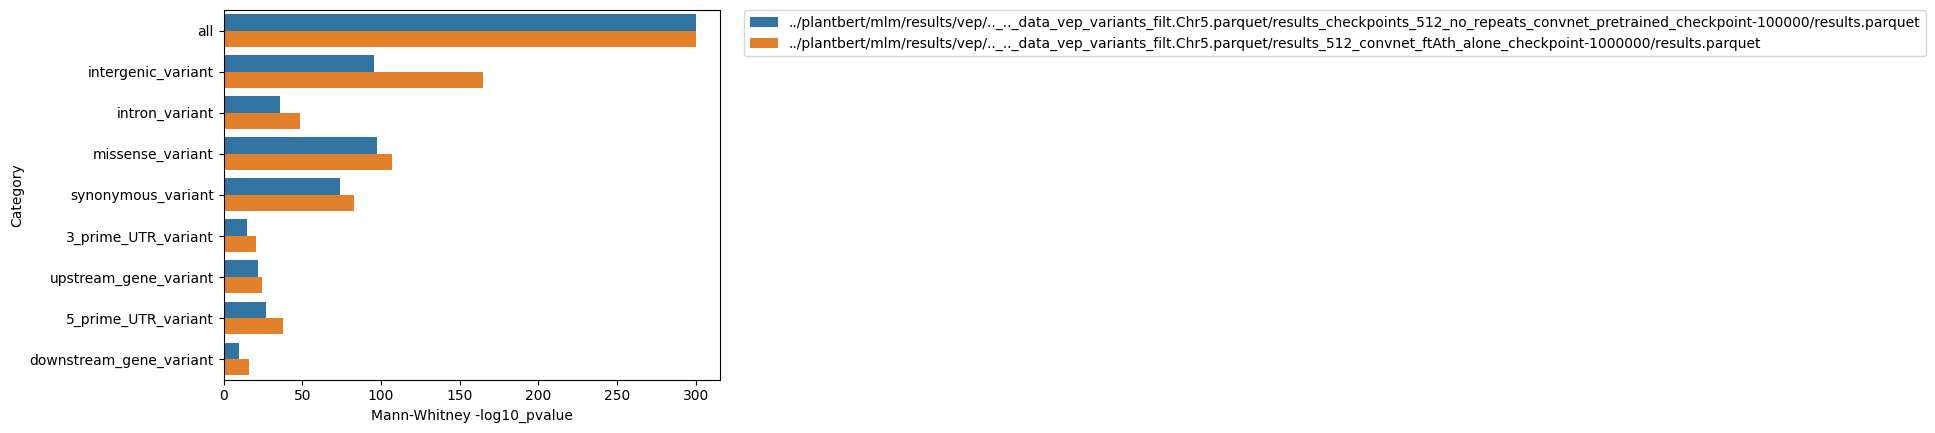

In [12]:
sns.barplot(
    y="Category",
    x="-log10_pvalue",
    hue="Model",
    data=results_mw,
)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel("Mann-Whitney -log10_pvalue")
#plt.savefig("mann_whitney.pdf", bbox_inches='tight')

In [13]:
results_auroc = results[results.Test=="AUROC"]
results_auroc

,threshold_quantile,odds_ratio,p_value,min_count,Test,bootstrap_seed,AUROC,AUPRC,Category,Model,Significant
311,NaN,NaN,NaN,NaN,AUROC,NaN,0.529786,NaN,all,../plantbert/mlm/results/vep/.._.._data_vep_va...,False
624,NaN,NaN,NaN,NaN,AUROC,NaN,0.523989,NaN,intergenic_variant,../plantbert/mlm/results/vep/.._.._data_vep_va...,False
937,NaN,NaN,NaN,NaN,AUROC,NaN,0.518127,NaN,intron_variant,../plantbert/mlm/results/vep/.._.._data_vep_va...,False
1250,NaN,NaN,NaN,NaN,AUROC,NaN,0.535297,NaN,missense_variant,../plantbert/mlm/results/vep/.._.._data_vep_va...,False
1563,NaN,NaN,NaN,NaN,AUROC,NaN,0.533877,NaN,synonymous_variant,../plantbert/mlm/results/vep/.._.._data_vep_va...,False
1876,NaN,NaN,NaN,NaN,AUROC,NaN,0.522082,NaN,3_prime_UTR_variant,../plantbert/mlm/results/vep/.._.._data_vep_va...,False
2189,NaN,NaN,NaN,NaN,AUROC,NaN,0.528842,NaN,upstream_gene_variant,../plantbert/mlm/results/vep/.._.._data_vep_va...,False
2502,NaN,NaN,NaN,NaN,AUROC,NaN,0.535136,NaN,5_prime_UTR_variant,../plantbert/mlm/results/vep/.._.._data_vep_va...,False
2815,NaN,NaN,NaN,NaN,AUROC,NaN,0.520621,NaN,downstream_gene_variant,../plantbert/mlm/results/vep/.._.._data_vep_va...,False
3128,NaN,NaN,NaN,NaN,AUROC,NaN,0.535182,NaN,all,../plantbert/mlm/results/vep/.._.._data_vep_va...,False


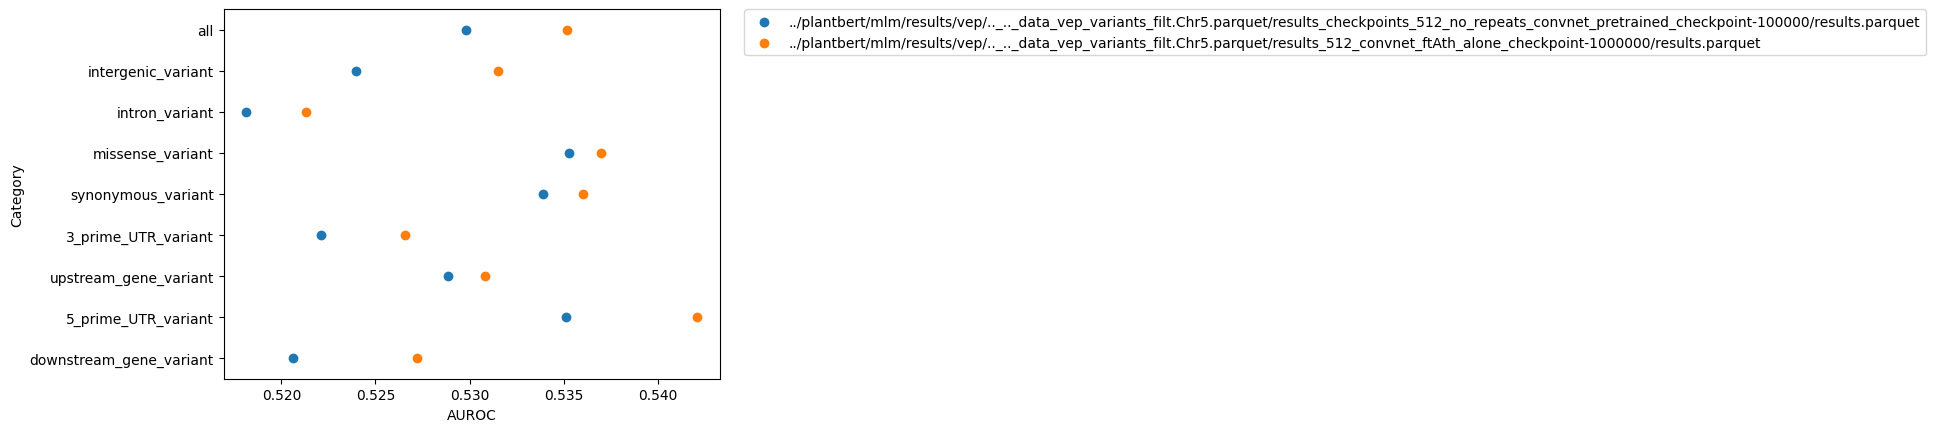

In [14]:
sns.pointplot(
    y="Category",
    x="AUROC",
    hue="Model",
    data=results_auroc,
    join=False,
    scale=0.8,
)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#plt.savefig("auroc.pdf", bbox_inches='tight')

In [15]:
results_auprc = results[results.Test=="AUPRC"]
results_auprc

,threshold_quantile,odds_ratio,p_value,min_count,Test,bootstrap_seed,AUROC,AUPRC,Category,Model,Significant
312,NaN,NaN,NaN,NaN,AUPRC,NaN,NaN,0.591903,all,../plantbert/mlm/results/vep/.._.._data_vep_va...,False
625,NaN,NaN,NaN,NaN,AUPRC,NaN,NaN,0.605622,intergenic_variant,../plantbert/mlm/results/vep/.._.._data_vep_va...,False
938,NaN,NaN,NaN,NaN,AUPRC,NaN,NaN,0.543913,intron_variant,../plantbert/mlm/results/vep/.._.._data_vep_va...,False
1251,NaN,NaN,NaN,NaN,AUPRC,NaN,NaN,0.656873,missense_variant,../plantbert/mlm/results/vep/.._.._data_vep_va...,False
1564,NaN,NaN,NaN,NaN,AUPRC,NaN,NaN,0.496854,synonymous_variant,../plantbert/mlm/results/vep/.._.._data_vep_va...,False
1877,NaN,NaN,NaN,NaN,AUPRC,NaN,NaN,0.585294,3_prime_UTR_variant,../plantbert/mlm/results/vep/.._.._data_vep_va...,False
2190,NaN,NaN,NaN,NaN,AUPRC,NaN,NaN,0.600403,upstream_gene_variant,../plantbert/mlm/results/vep/.._.._data_vep_va...,False
2503,NaN,NaN,NaN,NaN,AUPRC,NaN,NaN,0.608626,5_prime_UTR_variant,../plantbert/mlm/results/vep/.._.._data_vep_va...,False
2816,NaN,NaN,NaN,NaN,AUPRC,NaN,NaN,0.588293,downstream_gene_variant,../plantbert/mlm/results/vep/.._.._data_vep_va...,False
3129,NaN,NaN,NaN,NaN,AUPRC,NaN,NaN,0.598042,all,../plantbert/mlm/results/vep/.._.._data_vep_va...,False


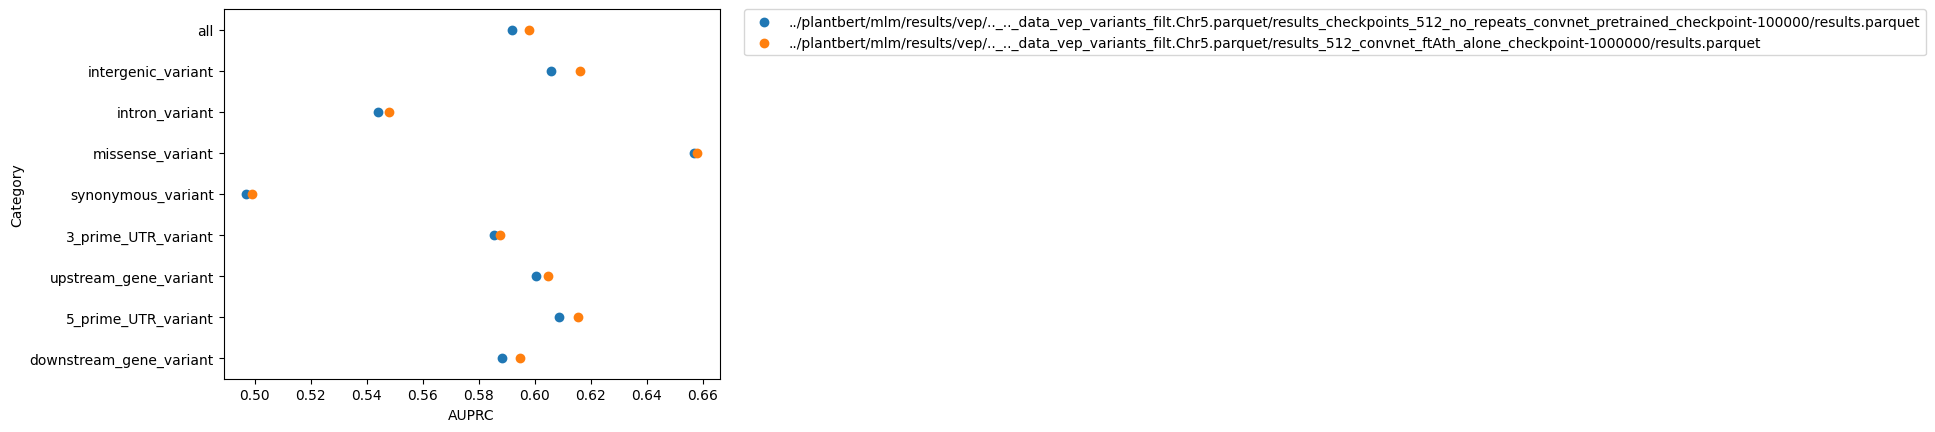

In [16]:
sns.pointplot(
    y="Category",
    x="AUPRC",
    hue="Model",
    data=results_auprc,
    join=False,
    scale=0.8,
)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#plt.savefig("auprc.pdf", bbox_inches='tight')

In [67]:
#df1 = pd.read_parquet(f"../plantbert/chromatin/vep_full_half1_DNABERT.parquet")
#df2 = pd.read_parquet(f"../plantbert/chromatin/vep_full_half2_DNABERT.parquet")
#df = pd.concat([df1, df2], ignore_index=True)
#df.to_parquet("../plantbert/chromatin/vep_full_DNABERT.parquet", index=False)

In [4]:
df = compute_vep_scores("mlm/window-512_tokenization-no_model-convnet800kfinetune200k")[1]
#df = compute_vep_scores("mlm/results_512_convnet_checkpoint-1000000",)
#df = compute_vep_scores("PhyloP")[1]
df

mlm/window-512_tokenization-no_model-convnet800kfinetune200k
Rare      512513
Common    394733
Name: Status, dtype: int64


,chromosome,pos,ref,alt,AC,AN,closest_TSS,dist_to_TSS,consequence,model_llr,AF,PhastCons,PhyloP,Status,model_score
0,Chr5,500,C,T,376,2078,AT5G01010.2,4494,downstream_gene_variant,1.445963,0.180943,0.000041,-2.247958,Common,1.445963
1,Chr5,504,T,C,2,2088,AT5G01010.2,4490,intergenic_variant,-1.122714,0.000958,0.005789,-0.031569,Rare,-1.122714
4,Chr5,512,A,G,2,2126,AT5G01010.2,4482,intergenic_variant,0.328421,0.000941,0.004241,0.006849,Rare,0.328421
5,Chr5,538,C,T,2,2158,AT5G01010.2,4456,intergenic_variant,-0.043589,0.000927,0.001401,-1.437007,Rare,-0.043589
6,Chr5,540,T,G,2,2194,AT5G01010.2,4454,intergenic_variant,-2.484268,0.000912,0.001881,0.066429,Rare,-2.484268
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1319359,Chr5,26974850,C,T,2,2028,AT5G67640.1,-4209,intergenic_variant,0.001271,0.000986,0.038742,-0.295663,Rare,0.001271
1319360,Chr5,26974862,G,A,2,2024,AT5G67640.1,-4221,intergenic_variant,1.164779,0.000988,0.440595,0.574454,Rare,1.164779
1319364,Chr5,26974883,A,C,2,2062,AT5G67640.1,-4242,intergenic_variant,0.285308,0.000970,0.029070,0.328652,Rare,0.285308
1319366,Chr5,26974907,G,A,2,2050,AT5G67640.1,-4266,intergenic_variant,-0.040504,0.000976,0.000014,-1.248585,Rare,-0.040504


In [101]:
consequence_scores = df.groupby("consequence").agg({"model_score": "mean", "pos": "size"}).rename(columns={"model_score": "mean_model_score", "pos": "counts"}).reset_index()
consequence_scores = consequence_scores[~consequence_scores.consequence.str.contains(',')]
consequence_scores = consequence_scores.sort_values("mean_model_score")
consequence_scores.sort_values("mean_model_score")

,consequence,mean_model_score,counts
451,non_coding_transcript_variant,-4.377555,2
460,splice_donor_variant,-3.151532,316
476,stop_gained,-2.807480,2337
456,splice_acceptor_variant,-2.528256,307
473,start_lost,-2.062667,186
408,missense_variant,-0.441404,126449
139,5_prime_UTR_variant,-0.436345,32502
315,intergenic_variant,-0.411152,258967
435,non_coding_transcript_exon_variant,-0.330648,6396
488,upstream_gene_variant,-0.302749,38330


In [102]:
consequence_scores = consequence_scores[consequence_scores.counts >= 100]
consequence_scores

,consequence,mean_model_score,counts
460,splice_donor_variant,-3.151532,316
476,stop_gained,-2.807480,2337
456,splice_acceptor_variant,-2.528256,307
473,start_lost,-2.062667,186
408,missense_variant,-0.441404,126449
139,5_prime_UTR_variant,-0.436345,32502
315,intergenic_variant,-0.411152,258967
435,non_coding_transcript_exon_variant,-0.330648,6396
488,upstream_gene_variant,-0.302749,38330
480,stop_lost,-0.296917,151


In [103]:
consequence_scores["consequence"] = consequence_scores.consequence + " (n=" + consequence_scores.counts.astype(str) + ")"
consequence_scores

,consequence,mean_model_score,counts
460,splice_donor_variant (n=316),-3.151532,316
476,stop_gained (n=2337),-2.807480,2337
456,splice_acceptor_variant (n=307),-2.528256,307
473,start_lost (n=186),-2.062667,186
408,missense_variant (n=126449),-0.441404,126449
139,5_prime_UTR_variant (n=32502),-0.436345,32502
315,intergenic_variant (n=258967),-0.411152,258967
435,non_coding_transcript_exon_variant (n=6396),-0.330648,6396
488,upstream_gene_variant (n=38330),-0.302749,38330
480,stop_lost (n=151),-0.296917,151


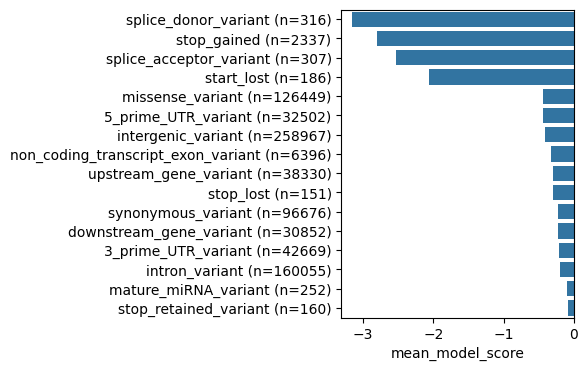

In [109]:
plt.figure(figsize=(3,4))
sns.barplot(
    data=consequence_scores,
    y="consequence", x="mean_model_score", color="C0"
);
plt.ylabel("")
plt.savefig("model_score_by_consequence.svg", bbox_inches='tight')

In [5]:
df

,chromosome,pos,ref,alt,AC,AN,closest_TSS,dist_to_TSS,consequence,model_llr,AF,PhastCons,PhyloP,Status,model_score
0,Chr5,500,C,T,376,2078,AT5G01010.2,4494,downstream_gene_variant,1.445963,0.180943,0.000041,-2.247958,Common,1.445963
1,Chr5,504,T,C,2,2088,AT5G01010.2,4490,intergenic_variant,-1.122714,0.000958,0.005789,-0.031569,Rare,-1.122714
4,Chr5,512,A,G,2,2126,AT5G01010.2,4482,intergenic_variant,0.328421,0.000941,0.004241,0.006849,Rare,0.328421
5,Chr5,538,C,T,2,2158,AT5G01010.2,4456,intergenic_variant,-0.043589,0.000927,0.001401,-1.437007,Rare,-0.043589
6,Chr5,540,T,G,2,2194,AT5G01010.2,4454,intergenic_variant,-2.484268,0.000912,0.001881,0.066429,Rare,-2.484268
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1319359,Chr5,26974850,C,T,2,2028,AT5G67640.1,-4209,intergenic_variant,0.001271,0.000986,0.038742,-0.295663,Rare,0.001271
1319360,Chr5,26974862,G,A,2,2024,AT5G67640.1,-4221,intergenic_variant,1.164779,0.000988,0.440595,0.574454,Rare,1.164779
1319364,Chr5,26974883,A,C,2,2062,AT5G67640.1,-4242,intergenic_variant,0.285308,0.000970,0.029070,0.328652,Rare,0.285308
1319366,Chr5,26974907,G,A,2,2050,AT5G67640.1,-4266,intergenic_variant,-0.040504,0.000976,0.000014,-1.248585,Rare,-0.040504


In [7]:
odds_ratio, p_value, min_counts = compute_odds_ratio(df[df.consequence=="upstream_gene_variant"], 1e-3, print_table=True)
odds_ratio, p_value, min_counts

Status  ModelScoreTier
Common  High              16232
        Low                   6
Rare    High              22059
        Low                  33
dtype: int64


(4.047146289496351, 0.00030769630324283307, 6)

In [72]:
df = pd.read_parquet("../plantbert/mlm/results/vep/.._.._data_vep_variants_filt.Chr5.parquet/results_512_convnet_ftAth_alone_checkpoint-1000000/results.parquet")
#df = pd.read_parquet("../plantbert/mlm/results/vep/.._.._data_vep_variants_filt.Chr5.parquet/results_checkpoints_512_no_repeats_convnet_pretrained_v2_checkpoint-200000/results.parquet")

df.rename(columns=dict(chromosome="chrom", pos="start"), inplace=True)
df["end"] = df.start + 1
df

,chrom,start,ref,alt,AC,AN,closest_TSS,dist_to_TSS,consequence,model_llr,end
0,Chr5,500,C,T,376,2078,AT5G01010.2,4494,downstream_gene_variant,1.679222,501
1,Chr5,504,T,C,2,2088,AT5G01010.2,4490,intergenic_variant,-1.429612,505
2,Chr5,505,A,G,4,2110,AT5G01010.2,4489,intergenic_variant,-0.920169,506
3,Chr5,510,G,A,6,2122,AT5G01010.2,4484,intergenic_variant,1.463465,511
4,Chr5,512,A,G,2,2126,AT5G01010.2,4482,intergenic_variant,0.410461,513
...,...,...,...,...,...,...,...,...,...,...,...
1444080,Chr5,26974897,C,T,6,2074,AT5G67640.1,-4256,intergenic_variant,-0.909240,26974898
1444081,Chr5,26974907,G,A,2,2050,AT5G67640.1,-4266,intergenic_variant,-0.045258,26974908
1444082,Chr5,26974913,C,T,6,2042,AT5G67640.1,-4272,intergenic_variant,0.925370,26974914
1444083,Chr5,26974918,C,T,4,2044,AT5G67640.1,-4277,intergenic_variant,-0.580203,26974919


In [76]:
df

,chrom,start,ref,alt,AC,AN,closest_TSS,dist_to_TSS,consequence,model_llr,end,AF
0,Chr5,500,C,T,376,2078,AT5G01010.2,4494,downstream_gene_variant,1.679222,501,0.180943
1,Chr5,504,T,C,2,2088,AT5G01010.2,4490,intergenic_variant,-1.429612,505,0.000958
2,Chr5,505,A,G,4,2110,AT5G01010.2,4489,intergenic_variant,-0.920169,506,0.001896
3,Chr5,510,G,A,6,2122,AT5G01010.2,4484,intergenic_variant,1.463465,511,0.002828
4,Chr5,512,A,G,2,2126,AT5G01010.2,4482,intergenic_variant,0.410461,513,0.000941
...,...,...,...,...,...,...,...,...,...,...,...,...
1444080,Chr5,26974897,C,T,6,2074,AT5G67640.1,-4256,intergenic_variant,-0.909240,26974898,0.002893
1444081,Chr5,26974907,G,A,2,2050,AT5G67640.1,-4266,intergenic_variant,-0.045258,26974908,0.000976
1444082,Chr5,26974913,C,T,6,2042,AT5G67640.1,-4272,intergenic_variant,0.925370,26974914,0.002938
1444083,Chr5,26974918,C,T,4,2044,AT5G67640.1,-4277,intergenic_variant,-0.580203,26974919,0.001957


In [73]:
#df = bf.coverage(df, repeats)
#df

In [74]:
#df = df.query('coverage == 0')
#df

In [77]:
df = df[df.AN >= 2000]
df = df[(df.AC != 0) & (df.AC != df.AN)]
df["AF"] = df.AC / df.AN
df = df[df.AC/df.AN < 0.5]
df

,chrom,start,ref,alt,AC,AN,closest_TSS,dist_to_TSS,consequence,model_llr,end,AF
0,Chr5,500,C,T,376,2078,AT5G01010.2,4494,downstream_gene_variant,1.679222,501,0.180943
1,Chr5,504,T,C,2,2088,AT5G01010.2,4490,intergenic_variant,-1.429612,505,0.000958
2,Chr5,505,A,G,4,2110,AT5G01010.2,4489,intergenic_variant,-0.920169,506,0.001896
3,Chr5,510,G,A,6,2122,AT5G01010.2,4484,intergenic_variant,1.463465,511,0.002828
4,Chr5,512,A,G,2,2126,AT5G01010.2,4482,intergenic_variant,0.410461,513,0.000941
...,...,...,...,...,...,...,...,...,...,...,...,...
1444080,Chr5,26974897,C,T,6,2074,AT5G67640.1,-4256,intergenic_variant,-0.909240,26974898,0.002893
1444081,Chr5,26974907,G,A,2,2050,AT5G67640.1,-4266,intergenic_variant,-0.045258,26974908,0.000976
1444082,Chr5,26974913,C,T,6,2042,AT5G67640.1,-4272,intergenic_variant,0.925370,26974914,0.002938
1444083,Chr5,26974918,C,T,4,2044,AT5G67640.1,-4277,intergenic_variant,-0.580203,26974919,0.001957


In [79]:
positions_paper = np.array([
    17883475,
    17883492,
    17883501,
    17883508,
    21818955,
    21818969
]) - 1
df7 = df.set_index("start")
df7.loc[positions_paper]

,chrom,ref,alt,AC,AN,closest_TSS,dist_to_TSS,consequence,model_llr,end,AF
start,,,,,,,,,,,
17883474,Chr5,A,C,146,2182,AT5G44390.1,1530,intron_variant,-0.213267,17883475,0.066911
17883491,Chr5,A,T,144,2178,AT5G44390.1,1513,intron_variant,0.683287,17883492,0.066116
17883500,Chr5,T,A,146,2194,AT5G44390.1,1504,intron_variant,-1.080920,17883501,0.066545
17883507,Chr5,T,G,144,2182,AT5G44390.1,1497,intron_variant,-1.504961,17883508,0.065995
21818954,Chr5,G,A,126,2174,AT5G53750.1,1588,3_prime_UTR_variant,0.954857,21818955,0.057958
21818968,Chr5,G,T,132,2190,AT5G53750.1,1602,downstream_gene_variant,1.171160,21818969,0.060274


In [15]:
df = df.sort_values("model_llr")
df

,chrom,start,ref,alt,AC,AN,closest_TSS,dist_to_TSS,consequence,model_llr,end,coverage,AF
278453,Chr5,5559261,G,C,132,2230,AT5G16910.1,-2418,"splice_donor_variant,splice_donor_variant,spli...",-8.689382,5559262,0,0.059193
773416,Chr5,15321307,T,A,10,2192,AT5G38340.1,800,"missense_variant,missense_variant,missense_var...",-8.308427,15321308,0,0.004562
73431,Chr5,1241647,T,G,2,2026,AT5G04400.1,92,missense_variant,-8.236891,1241648,0,0.000987
796389,Chr5,15772663,G,C,2,2212,AT5G39420.1,583,missense_variant,-8.164209,15772664,0,0.000904
688814,Chr5,13594286,A,T,2,2240,AT5G35380.1,2007,missense_variant,-8.137297,13594287,0,0.000893
...,...,...,...,...,...,...,...,...,...,...,...,...,...
750472,Chr5,14824800,T,G,968,2060,AT5G37380.4,-5504,intergenic_variant,5.987090,14824801,1,0.469903
727779,Chr5,14263093,A,T,52,2192,AT5G36220.1,-7060,intergenic_variant,6.093125,14263094,1,0.023723
710269,Chr5,13928707,C,A,4,2232,AT5G35753.1,-3435,intergenic_variant,6.124077,13928708,1,0.001792
1091084,Chr5,20429421,G,T,78,2248,AT5G50180.1,-1175,intergenic_variant,6.263269,20429422,0,0.034698


In [16]:
df.head(10)

,chrom,start,ref,alt,AC,AN,closest_TSS,dist_to_TSS,consequence,model_llr,end,coverage,AF
278453,Chr5,5559261,G,C,132,2230,AT5G16910.1,-2418,"splice_donor_variant,splice_donor_variant,spli...",-8.689382,5559262,0,0.059193
773416,Chr5,15321307,T,A,10,2192,AT5G38340.1,800,"missense_variant,missense_variant,missense_var...",-8.308427,15321308,0,0.004562
73431,Chr5,1241647,T,G,2,2026,AT5G04400.1,92,missense_variant,-8.236891,1241648,0,0.000987
796389,Chr5,15772663,G,C,2,2212,AT5G39420.1,583,missense_variant,-8.164209,15772664,0,0.000904
688814,Chr5,13594286,A,T,2,2240,AT5G35380.1,2007,missense_variant,-8.137297,13594287,0,0.000893
929925,Chr5,17683250,C,A,2,2192,AT5G43940.2,-906,stop_gained,-7.881779,17683251,0,0.000912
910202,Chr5,17372396,A,C,2,2234,AT5G43290.1,805,missense_variant,-7.851367,17372397,0,0.000895
1018207,Chr5,19180560,T,G,2,2096,AT5G47230.1,621,missense_variant,-7.805140,19180561,0,0.000954
271061,Chr5,5426200,C,A,2,2240,AT5G16580.1,1272,stop_gained,-7.712512,5426201,0,0.000893
349631,Chr5,6923832,T,G,2,2206,AT5G20480.1,1352,"missense_variant,missense_variant",-7.707416,6923833,0,0.000907


In [17]:
df.tail(10)

,chrom,start,ref,alt,AC,AN,closest_TSS,dist_to_TSS,consequence,model_llr,end,coverage,AF
84051,Chr5,1452610,T,C,164,2100,AT5G04940.1,4380,"intron_variant,splice_region_variant",5.659554,1452611,0,0.078095
1339203,Chr5,25001540,G,T,4,2244,AT5G62240.1,3226,"missense_variant,missense_variant",5.712293,25001541,0,0.001783
514452,Chr5,9914614,C,T,2,2212,AT5G27890.1,10974,intergenic_variant,5.717341,9914615,0,0.000904
708732,Chr5,13907407,C,T,184,2216,AT5G35737.1,243,missense_variant,5.727025,13907408,0,0.083032
243240,Chr5,4867014,A,C,412,2202,AT5G15020.1,-983,"downstream_gene_variant,downstream_gene_varian...",5.885877,4867015,0,0.187103
750472,Chr5,14824800,T,G,968,2060,AT5G37380.4,-5504,intergenic_variant,5.987090,14824801,1,0.469903
727779,Chr5,14263093,A,T,52,2192,AT5G36220.1,-7060,intergenic_variant,6.093125,14263094,1,0.023723
710269,Chr5,13928707,C,A,4,2232,AT5G35753.1,-3435,intergenic_variant,6.124077,13928708,1,0.001792
1091084,Chr5,20429421,G,T,78,2248,AT5G50180.1,-1175,intergenic_variant,6.263269,20429422,0,0.034698
514806,Chr5,9916685,G,T,2,2120,AT5G27890.1,13045,intergenic_variant,6.334364,9916686,1,0.000943


In [17]:
df["model_llr_percentile_bin"] = pd.qcut(df.model_llr, 100, labels=False)
df.model_llr_percentile_bin.value_counts()

45    12683
51    12683
87    12683
91    12683
63    12683
      ...  
85    12682
60    12682
25    12682
52    12682
46    12681
Name: model_llr_percentile_bin, Length: 100, dtype: int64

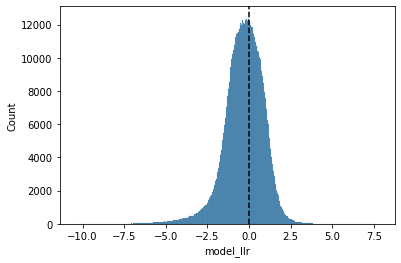

In [34]:
sns.histplot(
    data=df,
    x="model_llr"
)
plt.axvline(0, linestyle="--", color="black")

In [27]:
mean_AF = df.AF.mean()
mean_AF

0.027242815225905142

Text(0, 0.5, 'Mean AF')

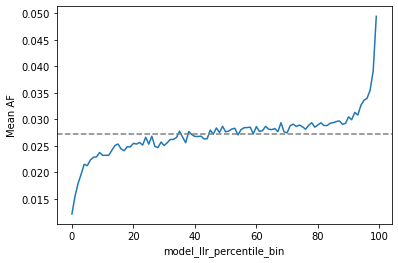

In [31]:
#g = sns.pointplot(
g = sns.lineplot(
    data=df,
    x="model_llr_percentile_bin",
    y="AF",
    color="C0",
    #join=False,
    ci=None,
    #s=2,
    markers=True,
)
plt.axhline(mean_AF, linestyle="--", color="grey")
plt.ylabel("Mean AF")

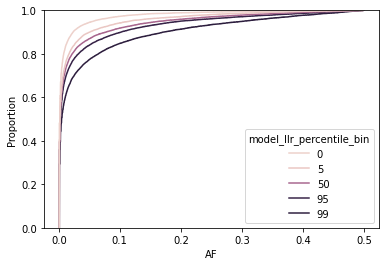

In [47]:
g = sns.ecdfplot(
    data=df[df.model_llr_percentile_bin.isin([0, 5, 50, 95, 99])],
    hue="model_llr_percentile_bin",
    x="AF",
    #stat="probability",
    #bins=10,
    #multiple="dodge",
)

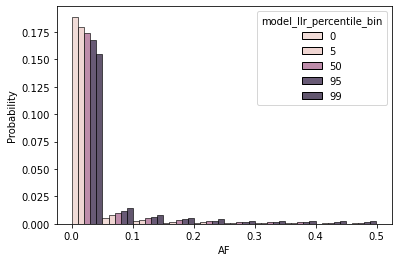

In [48]:
g = sns.histplot(
    data=df[df.model_llr_percentile_bin.isin([0, 5, 50, 95, 99])],
    hue="model_llr_percentile_bin",
    x="AF",
    stat="probability",
    bins=10,
    multiple="dodge",
)

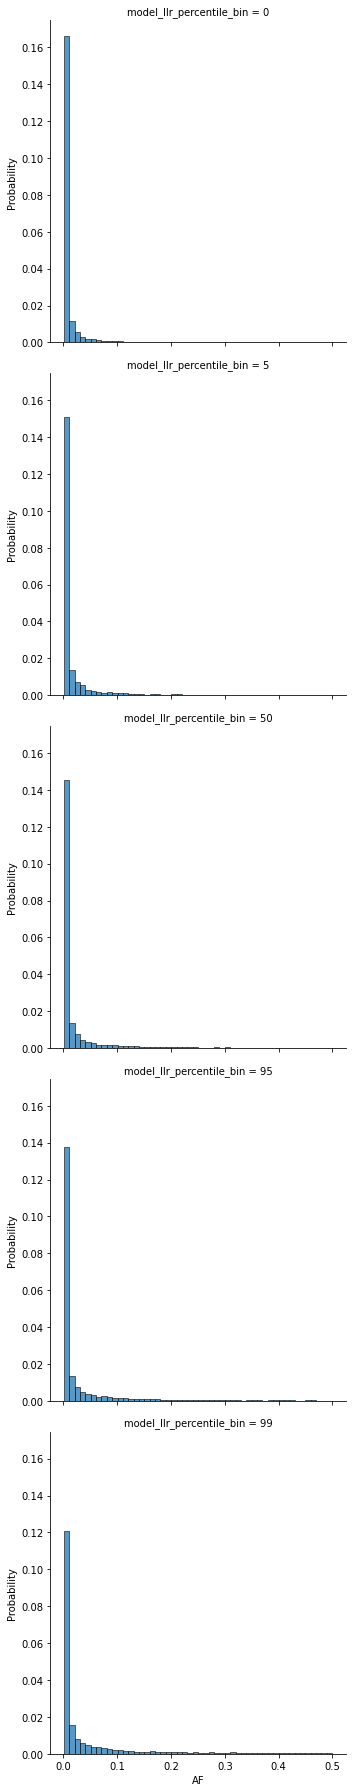

In [51]:
g = sns.displot(
    data=df[df.model_llr_percentile_bin.isin([0, 5, 50, 95, 99])],
    row="model_llr_percentile_bin",
    x="AF",
    stat="probability",
    bins=50,
)

In [7]:
df

,chrom,start,ref,alt,AC,AN,closest_TSS,dist_to_TSS,consequence,model_llr,end,AF
0,Chr5,500,C,T,376,2078,AT5G01010.2,4494,downstream_gene_variant,1.679222,501,0.180943
1,Chr5,504,T,C,2,2088,AT5G01010.2,4490,intergenic_variant,-1.429612,505,0.000958
2,Chr5,505,A,G,4,2110,AT5G01010.2,4489,intergenic_variant,-0.920169,506,0.001896
3,Chr5,510,G,A,6,2122,AT5G01010.2,4484,intergenic_variant,1.463465,511,0.002828
4,Chr5,512,A,G,2,2126,AT5G01010.2,4482,intergenic_variant,0.410461,513,0.000941
...,...,...,...,...,...,...,...,...,...,...,...,...
1444080,Chr5,26974897,C,T,6,2074,AT5G67640.1,-4256,intergenic_variant,-0.909240,26974898,0.002893
1444081,Chr5,26974907,G,A,2,2050,AT5G67640.1,-4266,intergenic_variant,-0.045258,26974908,0.000976
1444082,Chr5,26974913,C,T,6,2042,AT5G67640.1,-4272,intergenic_variant,0.925370,26974914,0.002938
1444083,Chr5,26974918,C,T,4,2044,AT5G67640.1,-4277,intergenic_variant,-0.580203,26974919,0.001957


In [8]:
# https://aragwas.1001genomes.org/api/associations/download/?&chr=5&annotation=ns&annotation=s&annotation=in&annotation=i&maf=1&maf=1-5&maf=5-10&maf=10&mac=5&type=genic&type=non-genic&significant=p

In [65]:
aragwas = pd.read_csv("aragwas_associations_chr_5_significant_permutation.csv")
aragwas["snp.position"] -= 1
aragwas.drop_duplicates("score", keep=False, inplace=True)
aragwas

/global/software/sl-7.x86_64/modules/langs/python/3.7/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (94,98,99,102,106,107,108,109,110,111,113,114,115,116) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,snp.chr,snp.position,score,maf,mac,study.name,study.id,study.phenotype.name,study.genotype.name,study.thresholds,...,snp.annotations.10.gene_name,snp.annotations.10.transcript_id,snp.annotations.10.effect,snp.annotations.10.impact,snp.annotations.10.rank,snp.annotations.11.gene_name,snp.annotations.11.transcript_id,snp.annotations.11.effect,snp.annotations.11.impact,snp.annotations.11.rank
4,chr5,2758120,29.582640,0.055888,28,"('clim-gs10_raw_Full imputed genotype_amm',)",577,clim-gs10,Full imputed genotype,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,chr5,4640223,29.087025,0.073684,7,"('YEL__raw_Full imputed genotype_amm',)",28,YEL,Full imputed genotype,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,chr5,26788831,27.159486,0.049900,25,"('clim-bio4_raw_Full imputed genotype_amm',)",567,clim-bio4,Full imputed genotype,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,chr5,5513288,26.747298,0.013972,7,"('clim-gs5_raw_Full imputed genotype_amm',)",583,clim-gs5,Full imputed genotype,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14,chr5,26872609,24.366746,0.043912,22,"('clim-bio4_raw_Full imputed genotype_amm',)",567,clim-bio4,Full imputed genotype,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21475,chr5,13741411,6.830658,0.107527,10,"('Li7_raw_Full imputed genotype_amm',)",101,Li7,Full imputed genotype,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21476,chr5,18503193,6.806693,0.198864,35,"('Anthocyanin_16_raw_Full imputed genotype_amm',)",61,Anthocyanin 16,Full imputed genotype,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21477,chr5,26227768,6.720372,0.236559,22,"('B11_raw_Full imputed genotype_amm',)",54,B11,Full imputed genotype,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21489,chr5,13102074,6.438809,0.015968,8,"('clim-pet3_raw_Full imputed genotype_amm',)",597,clim-pet3,Full imputed genotype,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [55]:
list(aragwas.columns)

['snp.chr',
 'snp.position',
 'score',
 'maf',
 'mac',
 'study.name',
 'study.id',
 'study.phenotype.name',
 'study.genotype.name',
 'study.thresholds',
 'overFDR',
 'overBonferroni',
 'overPermutation',
 'snp.ref',
 'snp.alt',
 'snp.coding',
 'snp.gene_name',
 'snp.annotations',
 'study.thresholds.0.name',
 'study.thresholds.0.value',
 'study.thresholds.1.name',
 'study.thresholds.1.value',
 'study.thresholds.2.name',
 'study.thresholds.2.value',
 'study.thresholds.3.name',
 'study.thresholds.3.value',
 'study.thresholds.4.name',
 'study.thresholds.4.value',
 'snp.annotations.0.gene_name',
 'snp.annotations.0.transcript_id',
 'snp.annotations.0.effect',
 'snp.annotations.0.impact',
 'snp.annotations.0.rank',
 'snp.annotations.1.gene_name',
 'snp.annotations.1.transcript_id',
 'snp.annotations.1.effect',
 'snp.annotations.1.impact',
 'snp.annotations.1.rank',
 'snp.annotations.2.gene_name',
 'snp.annotations.2.transcript_id',
 'snp.annotations.2.function',
 'snp.annotations.2.impact',


In [38]:
aragwas[["mac", "maf"]].describe()

,mac,maf
count,21502.000000,21502.000000
mean,9.043531,0.018309
std,10.769814,0.019067
min,6.000000,0.005671
25%,6.000000,0.012000
50%,7.000000,0.013972
75%,8.000000,0.016000
max,520.000000,0.491493


In [66]:
aragwas["snp.position"].unique().shape

(1131,)

In [67]:
# checked the first one 14024713 and it was filtered out because AN less than 2000
list(set(aragwas["snp.position"]).difference(df.start.values))[:10]

[14012422,
 12197919,
 11345951,
 9048099,
 12668964,
 16158769,
 17608768,
 12615745,
 1343559,
 10137671]

In [68]:
len(set(df.start.values).intersection(aragwas["snp.position"].values))

619

In [63]:
aragwas.drop_duplicates()

,snp.chr,snp.position,score,maf,mac,study.name,study.id,study.phenotype.name,study.genotype.name,study.thresholds,...,snp.annotations.10.transcript_id,snp.annotations.10.effect,snp.annotations.10.impact,snp.annotations.10.rank,snp.annotations.11.gene_name,snp.annotations.11.transcript_id,snp.annotations.11.effect,snp.annotations.11.impact,snp.annotations.11.rank,AN
0,chr5,902185,29.967642,0.037681,13,"('Co59_raw_Full imputed genotype_amm',)",279,Co59,Full imputed genotype,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,345.0
1,chr5,902307,29.967642,0.037681,13,"('Co59_raw_Full imputed genotype_amm',)",279,Co59,Full imputed genotype,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,345.0
2,chr5,26807057,29.632889,0.047904,24,"('clim-bio4_raw_Full imputed genotype_amm',)",567,clim-bio4,Full imputed genotype,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,501.0
3,chr5,26807056,29.632889,0.047904,24,"('clim-bio4_raw_Full imputed genotype_amm',)",567,clim-bio4,Full imputed genotype,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,501.0
4,chr5,2758120,29.582640,0.055888,28,"('clim-gs10_raw_Full imputed genotype_amm',)",577,clim-gs10,Full imputed genotype,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,501.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21497,chr5,26813487,6.394157,0.129032,12,"('B11_raw_Full imputed genotype_amm',)",54,B11,Full imputed genotype,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,93.0
21498,chr5,18571032,6.322100,0.409938,66,"('GR21_raw_Full imputed genotype_amm',)",294,GR21,Full imputed genotype,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,161.0
21499,chr5,18571737,6.322100,0.409938,66,"('GR21_raw_Full imputed genotype_amm',)",294,GR21,Full imputed genotype,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,161.0
21500,chr5,18571688,6.322100,0.409938,66,"('GR21_raw_Full imputed genotype_amm',)",294,GR21,Full imputed genotype,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,161.0


In [69]:
df = df[df.AC >= 6]
df

,chrom,start,ref,alt,AC,AN,closest_TSS,dist_to_TSS,consequence,model_llr,end,AF,GWAS_hit
0,Chr5,500,C,T,376,2078,AT5G01010.2,4494,downstream_gene_variant,1.679222,501,0.180943,False
3,Chr5,510,G,A,6,2122,AT5G01010.2,4484,intergenic_variant,1.463465,511,0.002828,False
9,Chr5,548,C,T,20,2182,AT5G01010.2,4446,intergenic_variant,0.359509,549,0.009166,False
11,Chr5,558,G,A,12,2176,AT5G01010.2,4436,intergenic_variant,-0.758004,559,0.005515,False
12,Chr5,559,A,C,10,2036,AT5G01010.2,4435,intergenic_variant,2.038264,560,0.004912,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1444072,Chr5,26974818,G,A,10,2014,AT5G67640.1,-4177,intergenic_variant,1.712686,26974819,0.004965,False
1444076,Chr5,26974865,G,A,6,2046,AT5G67640.1,-4224,intergenic_variant,1.352494,26974866,0.002933,False
1444077,Chr5,26974868,C,T,6,2042,AT5G67640.1,-4227,intergenic_variant,0.641163,26974869,0.002938,False
1444080,Chr5,26974897,C,T,6,2074,AT5G67640.1,-4256,intergenic_variant,-0.909240,26974898,0.002893,False


In [70]:
df["GWAS_hit"] = df.start.isin(aragwas["snp.position"].unique())
df.GWAS_hit.value_counts()

False    699322
True        619
Name: GWAS_hit, dtype: int64

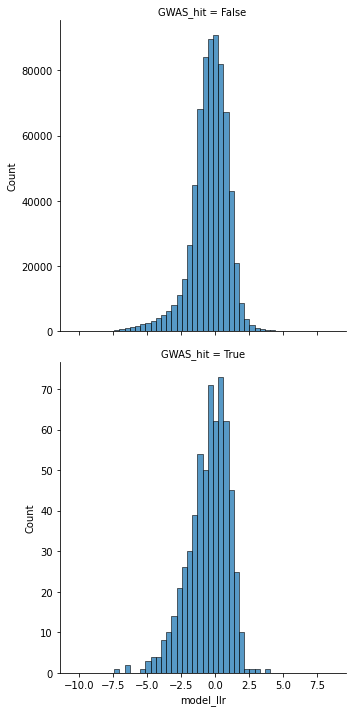

In [71]:
sns.displot(
    data=df,
    row="GWAS_hit",
    x="model_llr",
    stat="count",
    kind="hist",
    facet_kws=dict(sharey=False),
    bins=50,
)

In [57]:
aragwas_groupby = aragwas.groupby("snp.position").score.max().to_frame()
aragwas_groupby

,score
snp.position,
569,12.467616
20084,10.293022
89437,10.708900
150572,10.347442
442999,13.965251
...,...
26970982,14.217024
26972146,14.217024
26974038,14.217024


In [58]:
df5 = df.merge(aragwas_groupby, how="inner", left_on="start", right_index=True)
df5

,chrom,start,ref,alt,AC,AN,closest_TSS,dist_to_TSS,consequence,model_llr,end,AF,GWAS_hit,score
17,Chr5,569,G,A,24,2142,AT5G01010.2,4425,intergenic_variant,0.674958,570,0.011204,True,12.467616
1367,Chr5,20084,C,T,26,2188,AT5G01050.1,728,stop_gained,-4.307332,20085,0.011883,True,10.293022
5019,Chr5,89437,A,G,30,2188,AT5G01220.1,549,"intron_variant,intron_variant",-0.694389,89438,0.013711,True,10.708900
26220,Chr5,443085,G,A,46,2070,AT5G02220.1,-939,intergenic_variant,0.003092,443086,0.022222,True,13.965251
27195,Chr5,460761,C,T,52,2092,AT5G02260.1,-2397,intergenic_variant,1.123757,460762,0.024857,True,13.965251
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1443700,Chr5,26970915,A,G,82,2168,AT5G67640.1,-274,intergenic_variant,-1.035935,26970916,0.037823,True,14.217024
1443716,Chr5,26970982,A,G,98,2140,AT5G67640.1,-341,intergenic_variant,-2.183914,26970983,0.045794,True,14.217024
1443836,Chr5,26972146,T,A,94,2126,AT5G67640.1,-1505,downstream_gene_variant,-0.252052,26972147,0.044214,True,14.217024
1443986,Chr5,26974038,G,C,98,2086,AT5G67640.1,-3397,intergenic_variant,0.740364,26974039,0.046980,True,14.217024


<AxesSubplot:xlabel='score', ylabel='model_llr'>

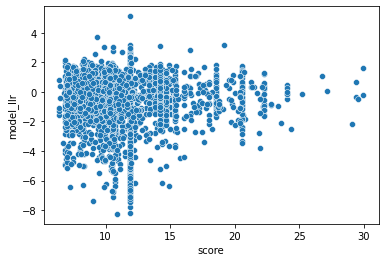

In [59]:
sns.scatterplot(
    data=df5,
    x="score",
    y="model_llr"
)